In [62]:
%matplotlib inline
#%display latex
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

## Abstract
In this paper we will discuss the mechanics behind the game of Snake and its application in graph theory.

# Objectives
Research and expand upon the following
1. Discuss what is the snake game.
2. How is the snake game related to graph theory?
3. What is a graph?
5. What is a Hamiltonian path and cycle?
6. Implement and discuss an algorithm for generating a Hamiltonian cycle.
7. Implement and discuss an algorithm for the snake to follow the path to the food.

# Bonus objectives (if there's time)
1. Explore the rendering pipeline and how to visualize the snake
2. Research the compute shader step of the pipeline to compute the algorithms in steps 6. and 7.

# Snake The Game
![Snake2](images/snake-day-FEATURED-desktop.png)
## Overview
Snake is a mobile game where the player controls a lengthening line, called the snake. The gameplay consists of rectangular grid of blocks, a snake and a food. The basic rules are the following:
1. The initial state of the game begins with a snake of length 1 and a food at two location on the board.
2. The snake can move in any of four directions: up, down, left, right. It can't move diagonally.
3. Once the snake eat's a food it's length increments by one and a new food spawns in unoccupied square on the board.
4. The snake wins, if it can collect all the foods on the board.
5. It loses, if its head collides with its body or any of the edges of the board.

## History
Snake is a mobile game designed for the monochrome 6110 Nokia phones$^{[1]}$. It was inspired by games like the arcade Blockage (1976), Bigfoot Bonkers (1977), Worm (1978) and Nibler (1982). The developer behind the game, Taneli Armano, was born in 1965 and had a passion for board games and computer programming. After studying computer science and and mathematics, he joined Nokia's user interface developing group and worked on the development of its first handsets. Taneli's interest in ringtones led him to programme the tones in some of the handsets, creating memorable musical accompaniments. Snake has become a staple in the mobile gaming industry, with many users recalling the tunes it provided$^{[2]}$.

The development of the game was faced with some limitations. Among them were the number of keys to control the game, a limited phone display of 48x84 black and white pixels and small memory. The game was designed in the C programming language and was hand-written line-by-line without the use of specific tools or code generators. During testing, Taneli noticed that making a 90-degree turn without crashing was dificult, leading him to add a small delay to the crash to help players react and save the snake. This delay allowed players to continue playing even with faster speeds.

Snake has left an incredible legacy, with over 420 Snake-like games available on iOs alone. Nokia, which had 51% of the global market share in 2007, was baffled by the introduced demand from the iPhone for less battery life and fragile screens, which led to Nokia's decline and in 2014, Microsoft aquired its mobile phone busines.

In [63]:
def create_graph_edges(nodes, is_weighted):
    '''
    create_graph_edges - create edges for a graph with the given nodes
    @param nodes - nodes for which to create the edges
    @param is_weighted - do the edges have values(True) or not(False)
    '''
    node_count = len(nodes)
    # determine how many edges will emerge from each node
    combos = list(combinations(nodes, 2))
    edges = [combos[i] for i in range(node_count)]
    
    if is_weighted:
        for i in range(len(edges)):
            rand_weight = float("{:.2f}".format(np.random.rand()))
            edges[i] += (rand_weight,)
    return edges

def draw_graph_edges(G, edges, pos, is_directed, is_weighted,
                     width = 3, arrowstyle = "->", arrowsize = 20):
    '''
    draw_graph_edges - draw the edges of the specified graph
    @param G - graph for which to draw the edges
    @param edges - edges to be drawn
    @param pos - (x, y) positions of the edges
    @param is_directed - are the edges directed(True) or not(False)
    @param is_weighted - do the edges have values(True) or not(False)
    @param width - width of the edge in pixels
    @param arrowstyle - style of the arrow, if the graph is directed
    @param arrowsize - size of the arrow, if the graph is directed
    '''
    def draw_edges(edge_list, alpha = None, edge_color="k", style="solid"):
        if is_directed:
            nx.draw_networkx_edges(G, pos, edgelist = edge_list, width = width,
                                   alpha = alpha, edge_color = edge_color, style = style,
                                   arrowstyle = arrowstyle, arrowsize = arrowsize)
        else:
            nx.draw_networkx_edges(G, pos, edgelist = edge_list, width = width,
                                  alpha = alpha, edge_color = edge_color, style = style)
    
    if is_weighted:
        large_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
        small_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]
        draw_edges(edge_list = large_edges)
        draw_edges(edge_list = small_edges, alpha = 0.5, edge_color = "b", style = "dashed")
        # edge weight labels
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels)
    else:
        draw_edges(edge_list = edges)

def graph_example(title, is_directed = False, is_weighted = False, node_count = 6, dpi = 240, seed = 6):
    '''
    graph_example - render a graph example
    @param title - title of the example graph
    @param is_directed - is the graph directed(True) or undirected(False)
    @param is_weighted - is the graph weighted(True) or unweighed(False)
    @param node_count - numer of nodes for the example graph
    @param dpi - dots per inch
    @param seed - position seed for reproducibility
    '''
    G = nx.DiGraph() if is_directed else nx.Graph()
    G.graph['dpi'] = dpi
    # Label the nodes with letters
    nodes = [chr(ord('@') + i + 1) for i in range(node_count)]
    # Create edges between each pair of nodes
    edges = create_graph_edges(nodes, is_weighted)
    G.add_nodes_from(nodes)
    if is_weighted:
        G.add_weighted_edges_from(edges)
    else:
        G.add_edges_from(edges)

    pos = nx.spring_layout(G, seed = seed)

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)
    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    draw_graph_edges(G, edges, pos, is_directed, is_weighted)
    plt.title(title)
    plt.show()

# Graph Theory
A graph is a mathematical structure that consists of a set of objects in which some of the objects are "related" to each other in some sense$^{[3]}$. The object is often denoted by the term vertex (also refered to as a node or point), while the "relation" is refered to as an edge. A more formal definition is the following

Definition 1. A graph is a pair $G = (V, E)$, where $V$ is a set whose elements are called vertices, and $E$ is a set of unordered pairs $\{v_{1}, v_{2}\}$ of vertices, whose elements are called edges.

A graph can categorized in several ways, including direction and weight of the edges$^{[4]}$.


Graph Theory is the study of graphs.

Definition 2. An undirected graph is such where the edges don't have a direction. The edges indicate a two-way relationship, in that each edge can be traversed in both directions.

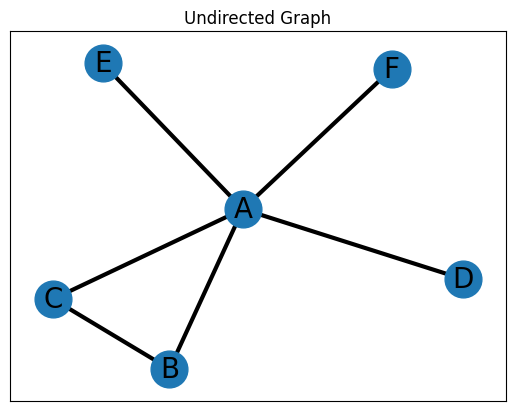

In [64]:
graph_example("Undirected Graph")

Definition 3. A directed graph is such where the edges have a direction going one way. The edges can only be traversed in one direction.

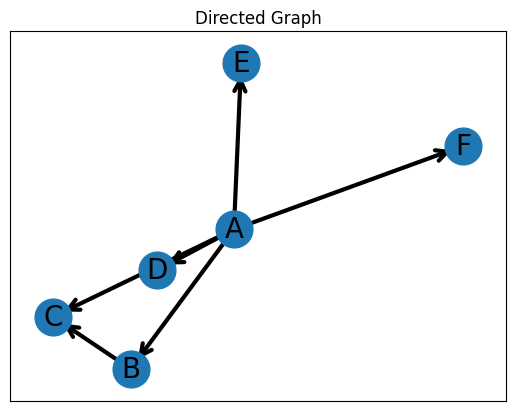

In [65]:
graph_example("Directed Graph", is_directed = True)

Definition 4. An unweighted graph is such where there is no value assigned to the edges. Alternatively each edge can be assumed to have a value of 1.

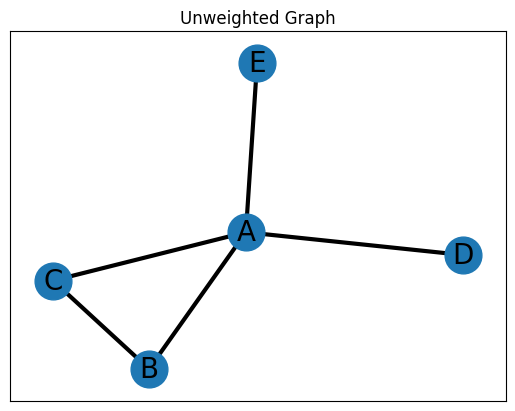

In [66]:
graph_example("Unweighted Graph", node_count = 5)

Definition 5. A weighted graph is such where each edge has an assigned value to it.

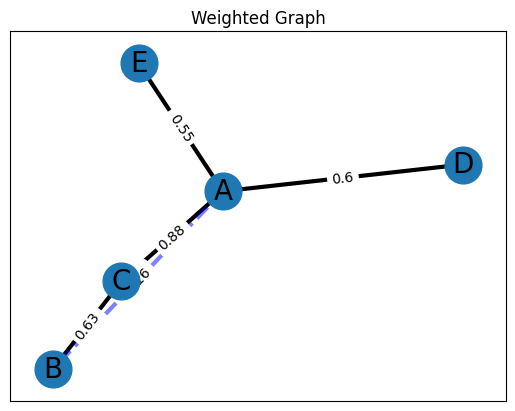

In [67]:
graph_example("Weighted Graph", is_weighted = True, node_count = 5)

Definition 6. The degree of a vertex$^{[5]}$ ${v}$ in an undirected graph ${G}$, denoted by $deg(v)$, is the number of edges incident with (meeting at or ending at) $v$.

# Bibliography
1. [The history of Snake: How the Nokia game defined a new era for the mobile industry, Ayla Angelos, Kyle Berger, 2021](https://www.itsnicethat.com/features/taneli-armanto-the-history-of-snake-design-legacies-230221)
2. [Nokia 1101 (1100) Ringtones, randomchannel1 TM, 2016](https://www.youtube.com/watch?v=vN88QnHfA7A)
3. [A Gentle Introduction to Graph Theory, Vaidehi Joshi, 2017](https://medium.com/basecs/a-gentle-introduction-to-graph-theory-77969829ead8)
4. [Graph Theory for Dummies, Sharafat Ibn Mollah Mosharraf, 2024](http://www.guides.sharafat.co.uk/documents/Graph_Theory_for_Dummies.pdf)
5. [Threshold Graphs And Related Topics, Annals of Discrete Mathematics, 1995](https://www.sciencedirect.com/topics/mathematics/degree-of-a-vertex)